In [1]:
import numpy as np
import torch
from torch import nn
from torchvision import datasets
from torchvision import transforms


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
import sys
sys.path.append("..")
from going_modular import engine,data_setup

/home/anshu/.venvs/alphaenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
normalize = transforms.Normalize(
    mean=[0.4914, 0.4822, 0.4465],
    std=[0.2023, 0.1994, 0.2010],
)

manual_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize]
)

In [5]:
data_dir = "data"

In [6]:
train_data = datasets.CIFAR10(
    root=data_dir,
    train=True,
    download=True,
    transform=manual_transform,
)

test_data = datasets.CIFAR10(
    root=data_dir,
    train=False,
    download=True,
    transform=manual_transform,
)


In [7]:
train_data,test_data

(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: data
     Split: Train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.201])
            ),
 Dataset CIFAR10
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.201])
            ))

In [8]:
img,label = train_data[3]

img.shape,label
# img

(torch.Size([3, 224, 224]), 4)

In [9]:
class_name = train_data.classes
class_name

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

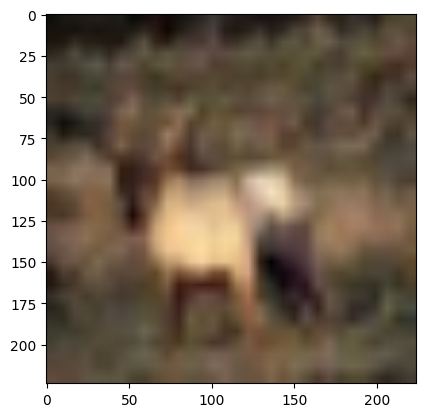

In [10]:
import matplotlib.pyplot as plt

img_min = img.min()
img_max = img.max()

# Normalize to [0, 1]
img_norm = (img - img_min) / (img_max - img_min)
# img_norm_255 = (img - img_min) / (img_max - img_min) * 255
# img_norm_255 = img_norm_255.byte()

plt.imshow(img_norm.permute(1,2,0))
# plt.imshow(img.permute(1,2,0))
# plt.imshow(img_norm_255.permute(1,2,0))

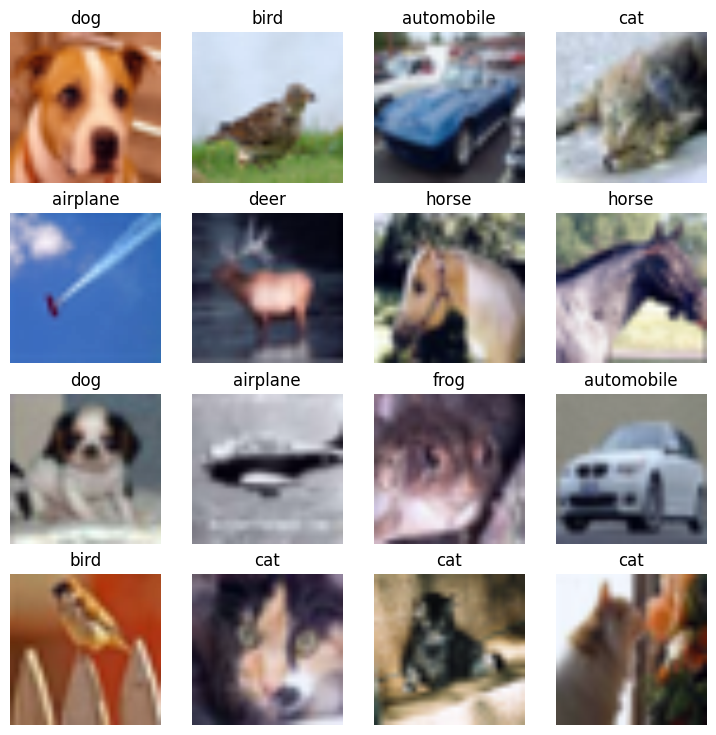

In [11]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4

for i in range(1,rows * cols +1):
    rand_idx = torch.randint(0,len(train_data),[1]).item() # .item to convert tensor to int
    img, label = train_data[rand_idx]
    img_min = img.min()
    img_max = img.max()
    
    img_norm = (img - img_min) / (img_max - img_min)
    
    fig.add_subplot(rows,cols,i)
    plt.imshow(img_norm.permute(1,2,0) , cmap='gray')
    plt.axis(False)
    plt.title(class_name[label])

### 1. Dataloader

In [12]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(train_data,BATCH_SIZE,shuffle=True)
test_dataloader = DataLoader(test_data,BATCH_SIZE,shuffle=False)

len(train_data),len(train_dataloader),len(test_data),len(test_dataloader)

(50000, 1563, 10000, 313)

In [13]:
batch_train_img,batch_train_label = next(iter(train_dataloader))

batch_train_img.shape,batch_train_label.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

## 2. Model
https://arxiv.org/abs/1512.03385

### 2.1 Residual Block

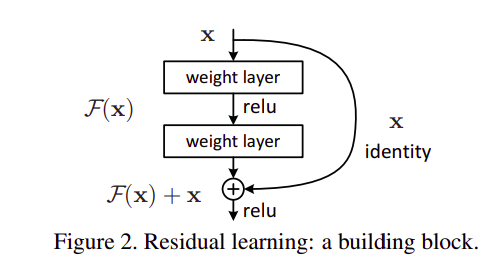
each weight layer is a conv block consisting of conv1,conv2,reLU() and convX consists of Conv2d and BatchNorm2d

In [50]:
class ResidualBlock(nn.Module):
    
    def __init__(self, in_channels:int , out_channels:int ,stride = 1 ,downsample = None):
        
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=stride,padding=1),
            nn.BatchNorm2d(out_channels)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=stride,padding=1),
            nn.BatchNorm2d(out_channels)
        )
        
        self.relu = nn.ReLU()
        
        self.downsample = downsample
        
        
    def forward(self,x):
        # returns F(x) + x (i.e adding identity or its projection)
        
        residual = x 
        out = self.conv1(x)
        out = self.relu(x)
        out = self.conv2(x)
        
        if(self.downsample):
            # dimension is different
            residual = self.downsample(x)
        
        out += residual # add the shortcut connection
        
        out = self.relu(out)
        
        return out
        

### 2.2  Res-Net
Below is the resnet class 

In [51]:
class ResNet(nn.Module):
    
    def __init__(self,block,num_classes = 10):
        
        super().__init__()
        self.in_channels = 64 # starting with conv1 7X7,64 stride 2
        
        # conv1 initiation
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=64,kernel_size=7,stride=2,padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        # conv2_x common max pool layer
        self.maxpool = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
        
        self.conv2_x = self.make_layer(block,64,3,stride = 1)
        self.conv3_x = self.make_layer(block,128,4,stride = 2)
        self.conv4_x = self.make_layer(block,256,6,stride = 2)
        self.conv5_x = self.make_layer(block,512,3,stride = 2)
        
        self.avgpool = nn.AvgPool2d(kernel_size=7,stride=1)
        self.classifier = nn.Linear(512,num_classes)
        
        
    def make_layer(self,block,out_channels,blocks,stride = 1):
        
        downsample = None
        
        if stride != 1 or self.in_channels != out_channels:
            
            # stride != 1 => no downsample for first layer(l0)
            # in != out => no downsample if in == out
            
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels,out_channels,kernel_size=1,stride=stride),
                nn.BatchNorm2d(out_channels)
            )
       
        layers = []
        
        # since last 3 layers has first RES-block with shortcut connection 
        # of different dimension so projection via downsample
        layers.append(block(self.in_channels,out_channels,stride = stride, downsample= downsample))
        
        # last output is anothers output
        self.in_channels = out_channels
        
        for i in range(1,blocks):
            layers.append(block(self.in_channels,out_channels))
        
        return nn.Sequential(*layers)
     
    
    def forward(self,x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.conv2_x(x)
        x = self.conv3_x(x)
        x = self.conv4_x(x)
        x = self.conv5_x(x)

        x = self.avgpool(x)
        
        x = torch.flatten(x,start_dim = 1)
        x = self.classifier(x)
        
        return x;

In [52]:
num_classes = len(class_name)
epochs = 1
BATCH_SIZE = 32
lr = 0.01

model = ResNet(ResidualBlock,num_classes)

#loss and optim
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters() , lr=lr , weight_decay=0.0001 , momentum= 0.9)

In [42]:
results = engine.train(model=model,
            train_dataloader=train_dataloader,
            test_dataloader=test_dataloader,
            optimizer=optimizer,
            loss_fn=loss_fn,
            epochs=epochs,
            device=device)



  0%|                                                     | 0/1 [00:00<?, ?it/s]

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

100%|████████████████████████████████████████████| 1/1 [09:50<00:00, 590.66s/it]

After conv1 :- torch.Size([32, 64, 112, 112])
After maxPool :- torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
torch.Size([32, 64, 56, 56])one block finished
After conv2 :- torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
torch.Size([32, 128, 28, 28])one block finished
After conv3 :- torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
torch.Size([32, 256, 14, 14])one block finished
After conv4 :- torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
torch.Size([32, 512, 7, 7])one block finished
After conv5 :- 

In [53]:
from torchinfo import summary
summary(model=model,input_size=[32,3,224,224],col_names=["input_size", "output_size","num_params"],col_width=20)

Layer (type:depth-idx)                   Input Shape          Output Shape         Param #
ResNet                                   [32, 3, 224, 224]    [32, 10]             --
├─Sequential: 1-1                        [32, 3, 224, 224]    [32, 64, 112, 112]   --
│    └─Conv2d: 2-1                       [32, 3, 224, 224]    [32, 64, 112, 112]   9,472
│    └─BatchNorm2d: 2-2                  [32, 64, 112, 112]   [32, 64, 112, 112]   128
│    └─ReLU: 2-3                         [32, 64, 112, 112]   [32, 64, 112, 112]   --
├─MaxPool2d: 1-2                         [32, 64, 112, 112]   [32, 64, 56, 56]     --
├─Sequential: 1-3                        [32, 64, 56, 56]     [32, 64, 56, 56]     --
│    └─ResidualBlock: 2-4                [32, 64, 56, 56]     [32, 64, 56, 56]     --
│    │    └─Sequential: 3-1              [32, 64, 56, 56]     [32, 64, 56, 56]     37,056
│    │    └─ReLU: 3-2                    [32, 64, 56, 56]     [32, 64, 56, 56]     --
│    │    └─Sequential: 3-3              

In [45]:
results

{'train_loss': [1.5418875843992008],
 'train_acc': [0.43863963531669864],
 'test_loss': [1.1360255797831014],
 'test_acc': [0.5883586261980831]}